# Setup

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
import scvi
import scrnatools as rna
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import logging
import scipy
from scipy.stats import spearmanr, pearsonr
import scanpy as sc

In [3]:
# Set seeds
scvi.settings.seed = 0
scvi.settings.verbosity = logging.WARNING

Global seed set to 0


In [4]:
# Setup figure params
plt.rcParams["pdf.use14corefonts"] = True
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = "Helvetica"
sc.set_figure_params(dpi=80, dpi_save=300, facecolor="white", frameon=False)
sns.set_context("paper")
plt.rcParams["axes.grid"] = False

In [5]:
warnings.resetwarnings()

# Import data

Data paths

In [6]:
rawDataPath = "/mnt/iacchus/joe/raw_data/"
processedDataPath = "/mnt/iacchus/joe/processed_data/"

In [7]:
# rawDataPath = "/mnt/e/Archive/Joe/raw_data/"
# processedDataPath = "/mnt/e/Archive/Joe/processed_data/"

In [8]:
aire_1 = sc.read(f"{processedDataPath}/Fezf2_thymus_paper/h5ad_files/pairwise_processing/aire_1_TECs.h5ad")
aire_1_model = scvi.model.SCVI.load(
    f"{processedDataPath}/Fezf2_thymus_paper/scVI_models/pairwise_processing/aire_1",
    adata=aire_1,
)

aire_2 = sc.read(f"{processedDataPath}/Fezf2_thymus_paper/h5ad_files/pairwise_processing/aire_2_TECs.h5ad")
aire_2_model = scvi.model.SCVI.load(
    f"{processedDataPath}/Fezf2_thymus_paper/scVI_models/pairwise_processing/aire_2",
    adata=aire_2,
)

fezf2_1 = sc.read(f"{processedDataPath}/Fezf2_thymus_paper/h5ad_files/pairwise_processing/fezf2_1_TECs.h5ad")
fezf2_1_model = scvi.model.SCVI.load(
    f"{processedDataPath}/Fezf2_thymus_paper/scVI_models/pairwise_processing/fezf2_1",
    adata=fezf2_1,
)

fezf2_2 = sc.read(f"{processedDataPath}/Fezf2_thymus_paper/h5ad_files/pairwise_processing/fezf2_2_TECs.h5ad")
fezf2_2_model = scvi.model.SCVI.load(
    f"{processedDataPath}/Fezf2_thymus_paper/scVI_models/pairwise_processing/fezf2_2",
    adata=fezf2_2,
)

adatas = {"Aire_1": aire_1, "Aire_2": aire_2, "Fezf2_1": fezf2_1, "Fezf2_2": fezf2_2}
models = {"Aire_1": aire_1_model, "Aire_2": aire_2_model, "Fezf2_1": fezf2_1_model, "Fezf2_2": fezf2_2_model}

In [9]:
fezf2_regulated_genes_data=pd.read_csv("../../analysis/Fezf2_microarray_DE_genes.csv", index_col=0)
fezf2_regulated_genes_data["-10logp"] = -1*np.log10(fezf2_regulated_genes_data["adj.P.Val"])

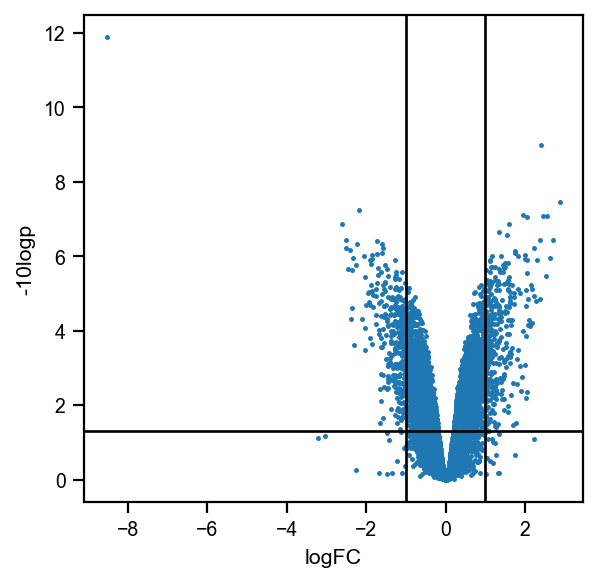

In [10]:
sns.scatterplot(
    fezf2_regulated_genes_data,
    x="logFC",
    y="-10logp",
    linewidth=0,
    s=5
)
plt.axhline(y=-1*np.log10(0.05), c="black")
plt.axvline(x=-1, c="black")
plt.axvline(x=1, c="black")
plt.show()

In [11]:
fezf2_regulated_genes_data = fezf2_regulated_genes_data[fezf2_regulated_genes_data["adj.P.Val"] < 0.05]
fezf2_regulated_genes_data = fezf2_regulated_genes_data[abs(fezf2_regulated_genes_data.logFC) > 2]
fezf2_regulated_genes_data = fezf2_regulated_genes_data[fezf2_regulated_genes_data.symbols != "Fezf2"]

In [12]:
fezf2_regulated_genes = fezf2_regulated_genes_data.symbols.unique()

# scVI DE

In [13]:
def scvi_cell_type_de(adata, model, cell_type_key, group_key, condition_group, control_group, collapse_on=None):
    all_genes = pd.DataFrame()

    for cell_type in adata.obs[cell_type_key].unique():
        subset_data = adata[adata.obs[cell_type_key] == cell_type].copy()
        num_control = sum([i == control_group for i in subset_data.obs[group_key]])
        num_condition = sum([i == condition_group for i in subset_data.obs[group_key]])
        if num_control > 3 and num_condition > 3: # Only run DE on cell types with at least 3 cells
            print(cell_type)
            de_genes = model.differential_expression(
                adata=subset_data,
                groupby=group_key,
                group1=condition_group,
                group2=control_group,
                silent=True,
                # filter_outlier_cells=True,
                # delta=None,
            )
            de_genes["cell_type"] = cell_type
            all_genes = pd.concat([all_genes, de_genes])
        else:
            print(f"{cell_type} had too few cells in at least one group, skipping")

    all_genes["gene"] = all_genes.index
    all_genes.index = all_genes.index + "_" + all_genes.cell_type
    all_genes = all_genes.sort_index()
    all_genes["abs_lfc"] = abs(all_genes.lfc_mean)
    
    if collapse_on is not None:
        all_genes_max = all_genes.sort_values(by=collapse_on, ascending=False).drop_duplicates('gene')
        all_genes_max.index = [i[0] for i in all_genes_max.index.str.split("_")]
        return all_genes, all_genes_max
    else:
        return all_genes

def filter_scvi_de_genes(adata, df, bayes_thresh, lfc_thresh, nonzero_thresh, peak_expression_thresh, ylim=None, collapse_on="abs_lfc", *args, **kwargs):
    ax = sns.scatterplot(
        x=df.lfc_mean,
        y=df.bayes_factor,
        linewidth=0,
        s=1,
        *args, **kwargs
    )
    plt.axhline(y=bayes_thresh, c="black")
    plt.axvline(x=lfc_thresh, c="black")
    plt.axvline(x=-1*lfc_thresh, c="black")
    if ylim is not None:
        plt.ylim(ylim)
    plt.show()
    
    filtered_genes = df[df.bayes_factor > bayes_thresh].copy()
    filtered_genes = filtered_genes[
        (filtered_genes.non_zeros_proportion1 > nonzero_thresh) |
        (filtered_genes.non_zeros_proportion2 > nonzero_thresh)
    ]
    filtered_genes = filtered_genes[abs(filtered_genes.lfc_mean) > lfc_thresh]
    
    # Filter genes with low peak normalized expression
    expression_filtered = pd.DataFrame(
        pd.DataFrame(
            adata[:, filtered_genes.gene.unique()].layers["scVI_normalized"],
            columns=filtered_genes.gene.unique()
        ).quantile(0.99)
    )
    expression_filtered = expression_filtered[expression_filtered[0.99] > peak_expression_thresh]
    filtered_genes = filtered_genes[filtered_genes.gene.isin(expression_filtered.index)]
    
    if collapse_on is not None:
        filtered_genes_max = filtered_genes.sort_values(by=collapse_on, ascending=False).drop_duplicates('gene')
        filtered_genes_max.index = [i[0] for i in filtered_genes_max.index.str.split("_")]
        return filtered_genes, filtered_genes_max
    else:
        return filtered_genes
    
def scvi_volcanoplot(df, gene_list, lfc_thresh=None, bayes_thresh=None, *args, **kwargs):
    ax=sns.scatterplot(
        df,
        x="lfc_mean",
        y="bayes_factor",
        s=10,
        linewidth=0,
        *args, **kwargs
    )
    for gene in gene_list:
        if gene in df.gene:
            plt.text(
                df[df.gene == gene].lfc_mean,
                df[df.gene == gene].bayes_factor,
                s=gene,
                color="black",
                fontdict={"fontsize":12},
            )
        else:
            print(f"{gene} not in DE gene dataframe")
    plt.ylabel("Bayes factor")
    plt.xlabel("LFC Mean")
    if lfc_thresh is not None:
        plt.axvline(x=lfc_thresh, color="black", linestyle="--")
        plt.axvline(x=-1*lfc_thresh, color="black", linestyle="--")
    if bayes_thresh is not None:
        plt.axhline(y=bayes_thresh, color="black", linestyle="--")
    plt.show()
    
def plot_cell_type_expression(df, plot_dictionary, gene_data, *args, **kwargs):
    for gene, cell_types in plot_dictionary.items():
        for cell_type in cell_types:
            subset_data = adata[adata.obs.majority_voting == cell_type, gene]
            data = rna.tl.get_expression_matrix(subset_data, gene_data=gene_data)
            data["genotype"] = subset_data.obs.genotype
            data["cell_type"] = subset_data.obs.majority_voting
            fig,axs = plt.subplots(1,2, figsize=(8,4), gridspec_kw={'width_ratios': [1, 3]})
            sns.boxplot(
                data,
                x="cell_type",
                y=gene,
                hue="genotype",
                hue_order=["WT", "Aire_KO", "Fezf2_KO"],
                ax=axs[0],
            )
            axs[0].set_xlabel("")
            axs[0].set_ylabel(gene_data)
            ax = sns.kdeplot(
                data,
                x=gene,
                hue="genotype",
                hue_order=["WT", "Aire_KO", "Fezf2_KO"],
                ax=axs[1],
                common_norm=False,
                *args, **kwargs
            )
            plt.suptitle(f"{gene}: {cell_type}")
            axs[1].set_xlabel(gene_data)
            plt.tight_layout()
            plt.show()
            
def plot_dataset_expression(adata, gene_list, gene_data, *args, **kwargs):
    data = rna.tl.get_expression_matrix(adata[:, gene_list], gene_data=gene_data)
    data["1"] = 1
    data["genotype"] = adata.obs.genotype
    for gene in gene_list:
        fig,axs = plt.subplots(1,2, figsize=(8,4), gridspec_kw={'width_ratios': [1, 3]})
        sns.boxplot(
            data,
            x="1",
            y=gene,
            hue="genotype",
            hue_order=["WT", "Aire_KO", "Fezf2_KO"],
            ax=axs[0],
        )
        axs[0].set_xticks([])
        axs[0].set_xlabel("")
        axs[0].set_ylabel(gene_data)
        sns.kdeplot(
            data,
            x=gene,
            hue="genotype",
            hue_order=["WT", "Aire_KO", "Fezf2_KO"],
            ax=axs[1],
            common_norm=False,
            log_scale=True,
            *args, **kwargs
        )
        plt.suptitle(gene)
        axs[1].set_xlabel(gene_data)
        plt.tight_layout()
        plt.show()
        
def plot_dataset_feature_plots(adata, gene_list, condition_key, condition_group, control_group, gene_data, *args, **kwargs):
    vmin = []
    vmax = []
    for gene in gene_list:
        data = adata[adata.obs[condition_key] == control_group, gene].layers[gene_data]
        if scipy.sparse.issparse(data):
            data = data.todense().tolist()
        vmin.append(np.quantile(data, 0.01))
        vmax.append(np.quantile(data, 0.99))

    sc.pl.umap(
        adata[adata.obs[condition_key] == control_group],
        color=gene_list,
        layer=gene_data,
        vmin=vmin,
        vmax=vmax,
        *args, **kwargs
    )
    sc.pl.umap(
        adata[adata.obs[condition_key] == condition_group],
        color=gene_list,
        layer=gene_data,
        vmin=vmin,
        vmax=vmax,
        *args, **kwargs
    )

## Run DE

In [14]:
all_genes = {}
all_genes_max_lfc = {}
for key, adata in adatas.items():
    print(key)
    all_gene, all_gene_max_lfc = scvi_cell_type_de(
        adata=adata,
        model=models[key],
        cell_type_key="majority_voting",
        group_key="genotype",
        condition_group=f"{key.split('_')[0]}_KO",
        control_group=f"{key.split('_')[0]}_WT",
        collapse_on="abs_lfc"
    )
    all_genes[key] = all_gene
    all_genes_max_lfc[key] = all_gene_max_lfc
    print()

Aire_1
TA MEC
Aire-stage
Ciliated had too few cells in at least one group, skipping
Skin, basal
Neuroendocrine
Immature MEC
Gut/Liver
Tuft2
Lung, basal
Mcell
adult cTEC
Tuft1
Goblet

Aire_2
Gut/Liver
Aire-stage
Immature MEC
Tuft2
Ciliated had too few cells in at least one group, skipping
Lung, basal
Skin, basal
adult cTEC
TA MEC
Tuft1
Neuroendocrine
Mcell
Goblet

Fezf2_1
Tuft2
Immature MEC
Aire-stage
Neuroendocrine
Skin, keratinized
Gut/Liver
Goblet
Tuft1
Lung, basal
Mcell
TA MEC
Skin, basal
adult cTEC
Ciliated

Fezf2_2
TA MEC
Aire-stage
Gut/Liver
Tuft2
Skin, basal
Lung, basal
Neuroendocrine
Immature MEC
Tuft1
Mcell
adult cTEC
Goblet
Skin, keratinized
Ciliated



## Filter

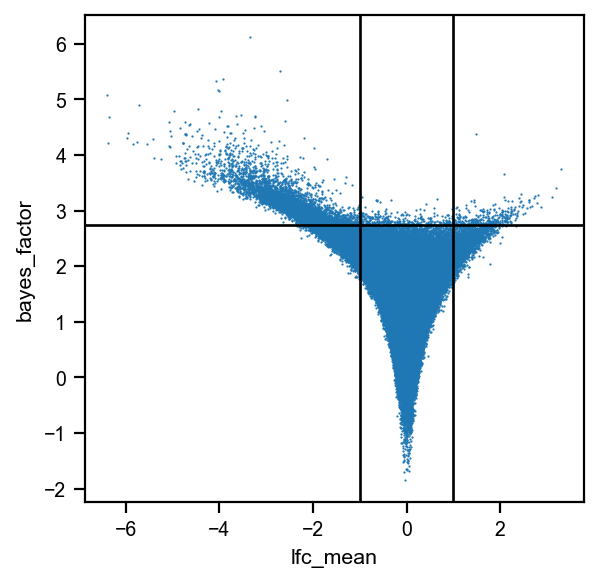

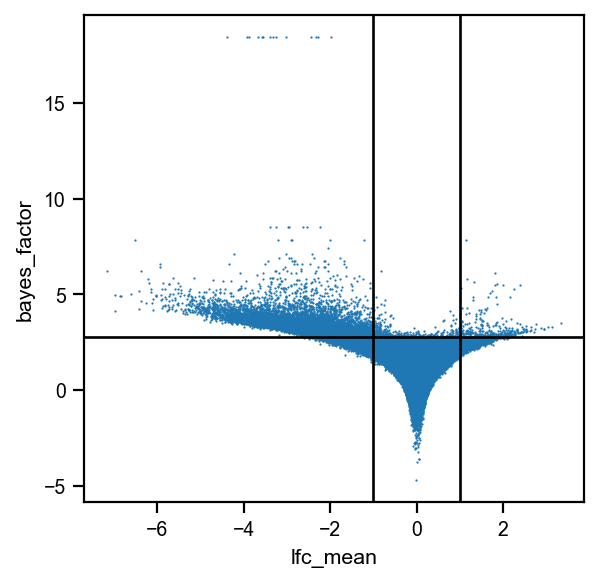

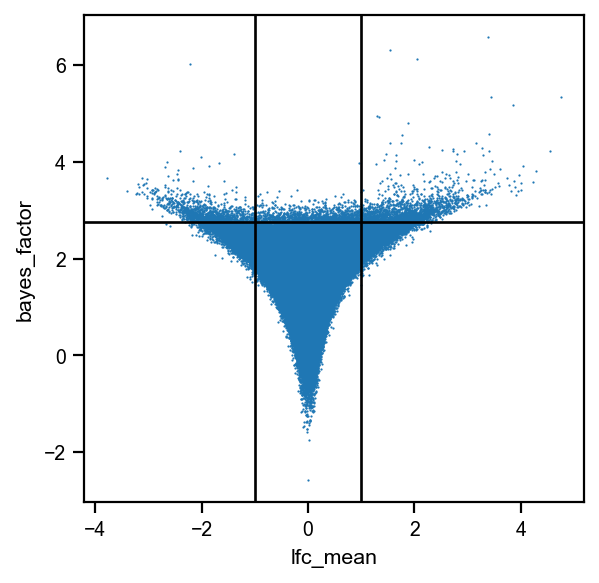

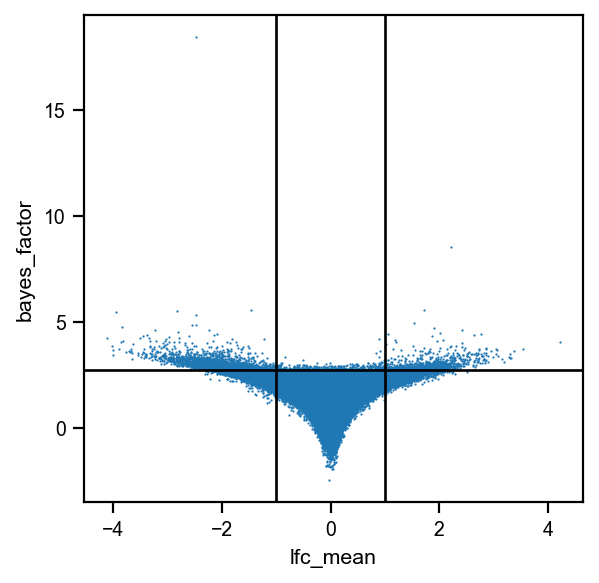

In [102]:
filtered_genes = {}
filtered_genes_max_lfc = {}
for key, adata in adatas.items():
    filtered_gene, filtered_gene_max_lfc_ = filter_scvi_de_genes(
        adata=adata,
        df=all_genes[key],
        bayes_thresh=2.75,
        lfc_thresh=1,
        nonzero_thresh=0.01,
        peak_expression_thresh=0.5,
        ylim=None,
        collapse_on="abs_lfc",
    )
    
    filtered_genes[key] = filtered_gene
    filtered_genes_max_lfc[key] = filtered_gene_max_lfc_

## sample overlap

### Fezf2

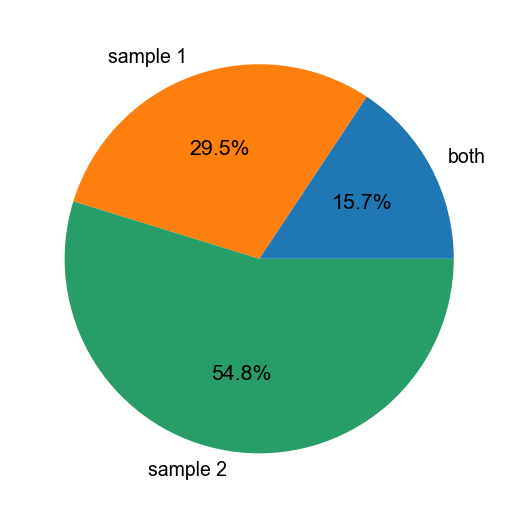

In [103]:
fezf2_1_filtered = filtered_genes_max_lfc["Fezf2_1"].copy()
fezf2_2_filtered = filtered_genes_max_lfc["Fezf2_2"].copy()

both = fezf2_1_filtered[
    fezf2_1_filtered.index.isin(fezf2_2_filtered.index)
].copy()
both.loc[:,"sample"] = "both"

sample_1 = fezf2_1_filtered[
    ~fezf2_1_filtered.index.isin(fezf2_2_filtered.index)
].copy()
sample_1.loc[:,"sample"] = "1"

sample_2 = fezf2_2_filtered[
    ~fezf2_2_filtered.index.isin(fezf2_1_filtered.index)
].copy()
sample_2.loc[:,"sample"] = "1"

fezf2_regulated = pd.concat([both, sample_1, sample_2])
fezf2_regulated["sample"] = fezf2_regulated["sample"].astype("category")
fezf2_regulated["sample"].cat = fezf2_regulated["sample"].cat.reorder_categories(["1", "both"])

sizes = [both.shape[0], sample_1.shape[0], sample_2.shape[0]]
labels = ["both", "sample 1", "sample 2"]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
# plt.title("Aire KO filtered DE genes")
plt.show()

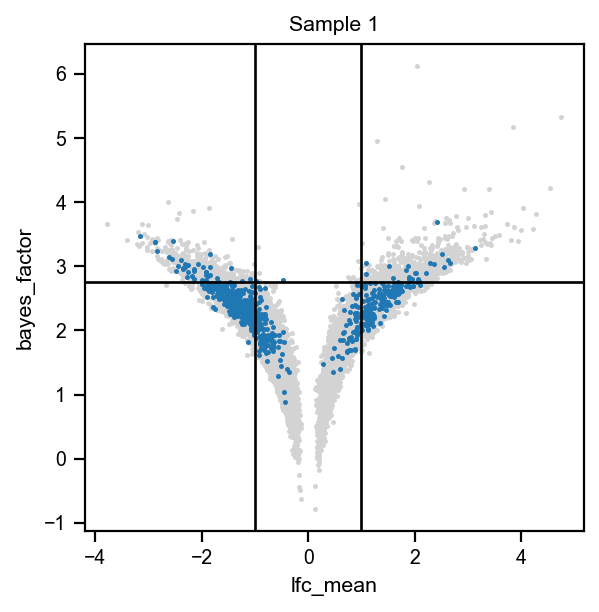

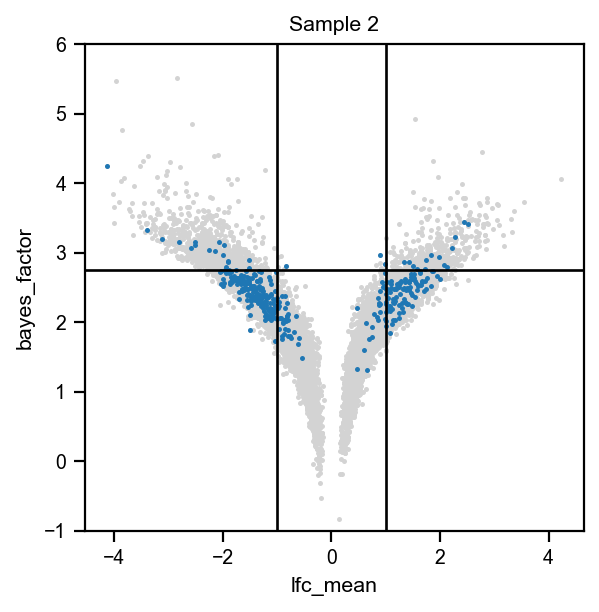

In [104]:
fezf2_1_all = all_genes_max_lfc["Fezf2_1"].copy()
fezf2_2_all = all_genes_max_lfc["Fezf2_2"].copy()
sns.scatterplot(
    x=fezf2_1_all.lfc_mean,
    y=fezf2_1_all.bayes_factor,
    linewidth=0,
    s=5,
    c="lightgrey"
)
sns.scatterplot(
    x=fezf2_1_all[fezf2_1_all.index.isin(sample_2.index)].lfc_mean,
    y=fezf2_1_all[fezf2_1_all.index.isin(sample_2.index)].bayes_factor,
    linewidth=0,
    s=5
)
plt.axhline(y=2.75, c="black")
plt.axvline(x=1, c="black")
plt.axvline(x=-1, c="black")
plt.title("Sample 1")
plt.show()

sns.scatterplot(
    x=fezf2_2_all.lfc_mean,
    y=fezf2_2_all.bayes_factor,
    linewidth=0,
    s=5,
    c="lightgrey"
)
sns.scatterplot(
    x=fezf2_2_all[fezf2_2_all.index.isin(sample_1.index)].lfc_mean,
    y=fezf2_2_all[fezf2_2_all.index.isin(sample_1.index)].bayes_factor,
    linewidth=0,
    s=5
)
plt.ylim((-1,6))
plt.axhline(y=2.75, c="black")
plt.axvline(x=1, c="black")
plt.axvline(x=-1, c="black")
plt.title("Sample 2")
plt.show()

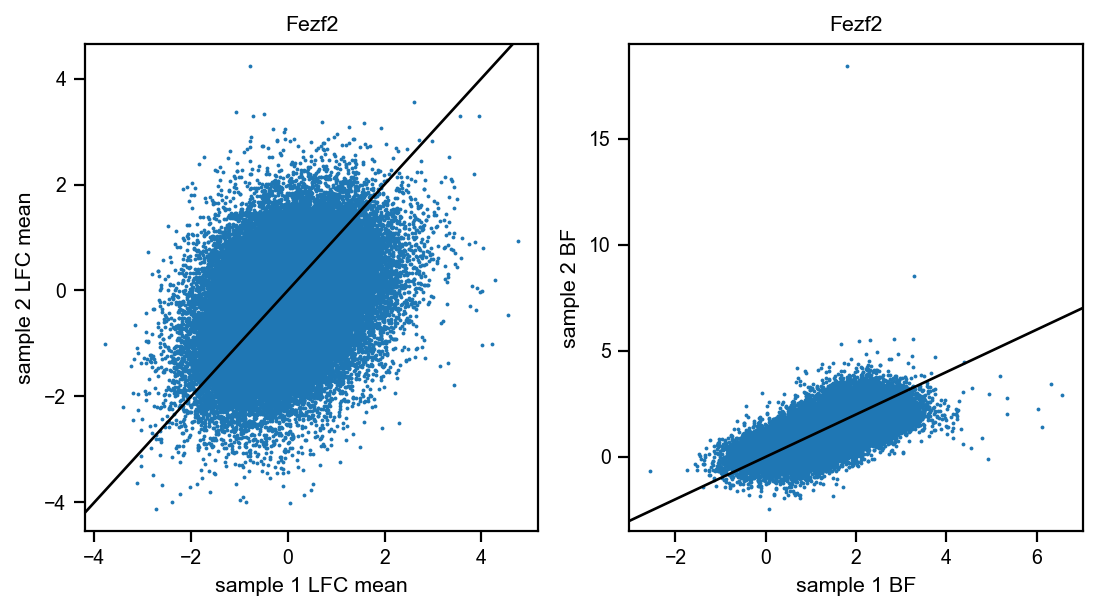

In [105]:
all_fezf2_1 = all_genes["Fezf2_1"]
all_fezf2_2 = all_genes["Fezf2_2"]

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
ax = sns.scatterplot(
    x=all_fezf2_1.lfc_mean,
    y=all_fezf2_2.lfc_mean,
    s=3,
    linewidth=0
)
ax.axline((0, 0), slope=1, c="black")
ax.set_title("Fezf2")
ax.set_xlabel("sample 1 LFC mean")
ax.set_ylabel("sample 2 LFC mean")

plt.subplot(1,2,2)
ax = sns.scatterplot(
    x=all_fezf2_1.bayes_factor,
    y=all_fezf2_2.bayes_factor,
    s=3,
    linewidth=0
)
ax.axline((0, 0), slope=1, c="black")
ax.set_title("Fezf2")
ax.set_xlabel("sample 1 BF")
ax.set_ylabel("sample 2 BF")
plt.show()

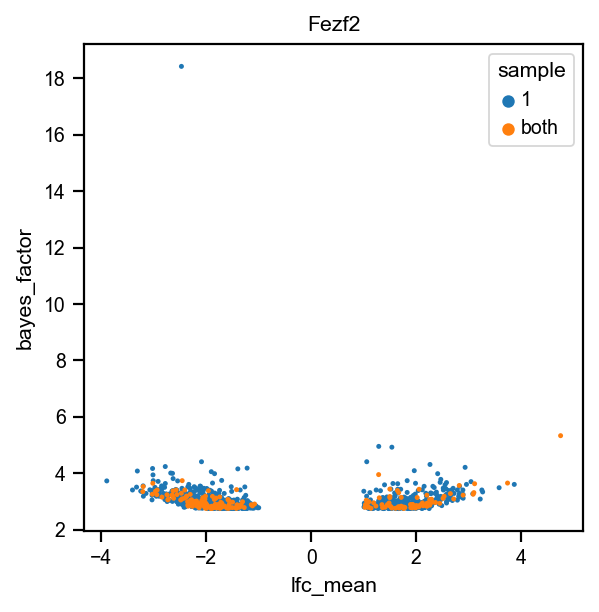

In [106]:
sns.scatterplot(
    fezf2_regulated[fezf2_regulated["sample"] == "1"],
    x="lfc_mean",
    y="bayes_factor",
    hue="sample",
    s=5,
    linewidth=0,
)
sns.scatterplot(
    fezf2_regulated[fezf2_regulated["sample"] == "both"],
    x="lfc_mean",
    y="bayes_factor",
    hue="sample",
    s=5,
    legend=None,
    linewidth=0,
)
plt.title("Fezf2")
plt.show()

### Aire

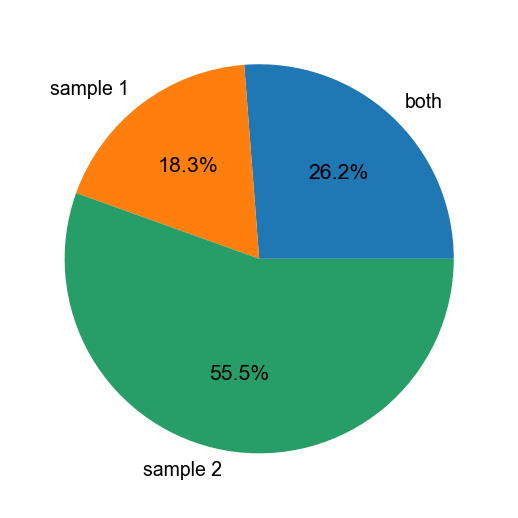

In [107]:
aire_1_filtered = filtered_genes_max_lfc["Aire_1"].copy()
aire_2_filtered = filtered_genes_max_lfc["Aire_2"].copy()

both = aire_1_filtered[
    aire_1_filtered.index.isin(aire_2_filtered.index)
].copy()
both.loc[:, "sample"] = "both"

sample_1 = aire_1_filtered[
    ~aire_1_filtered.index.isin(aire_2_filtered.index)
].copy()
sample_1.loc[:, "sample"] = "1"

sample_2 = aire_2_filtered[
    ~aire_2_filtered.index.isin(aire_1_filtered.index)
].copy()
sample_2.loc[:, "sample"] = "1"

aire_regulated = pd.concat([both, sample_1, sample_2])
aire_regulated["sample"] = aire_regulated["sample"].astype("category")
aire_regulated["sample"].cat = aire_regulated["sample"].cat.reorder_categories(["1", "both"])

sizes = [both.shape[0], sample_1.shape[0], sample_2.shape[0]]
labels = ["both", "sample 1", "sample 2"]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
# plt.title("Aire KO filtered DE genes")
plt.show()

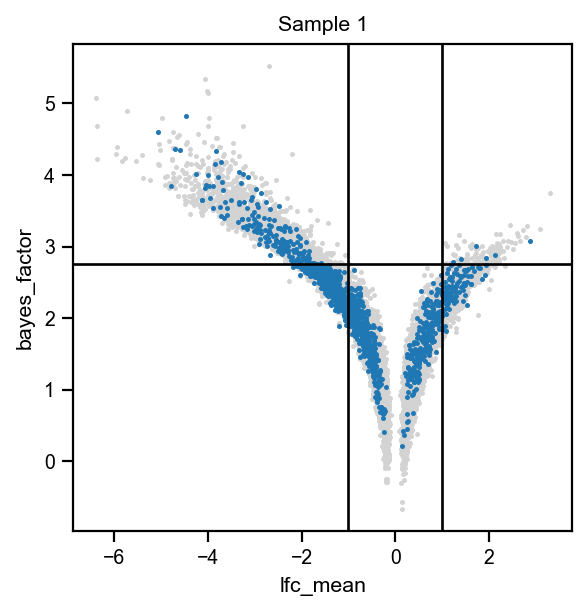

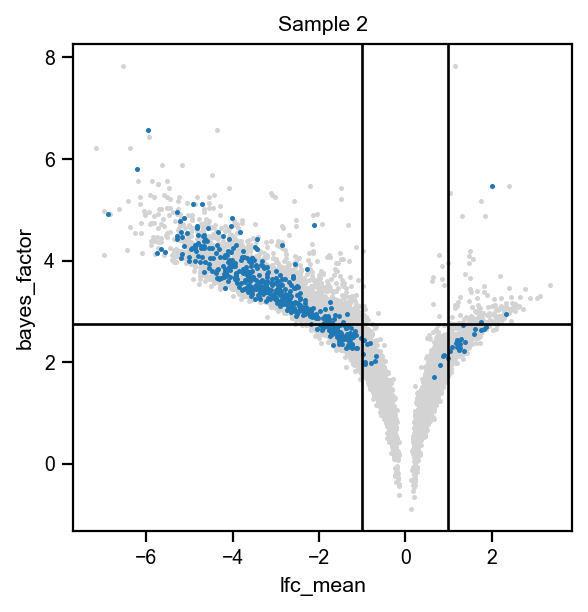

In [108]:
aire_1_all = all_genes_max_lfc["Aire_1"].copy()
aire_2_all = all_genes_max_lfc["Aire_2"].copy()
sns.scatterplot(
    x=aire_1_all.lfc_mean,
    y=aire_1_all.bayes_factor,
    linewidth=0,
    s=5,
    c="lightgrey"
)
sns.scatterplot(
    x=aire_1_all[aire_1_all.index.isin(sample_2.index)].lfc_mean,
    y=aire_1_all[aire_1_all.index.isin(sample_2.index)].bayes_factor,
    linewidth=0,
    s=5
)
plt.axhline(y=2.75, c="black")
plt.axvline(x=1, c="black")
plt.axvline(x=-1, c="black")
plt.title("Sample 1")
plt.show()

sns.scatterplot(
    x=aire_2_all.lfc_mean,
    y=aire_2_all.bayes_factor,
    linewidth=0,
    s=5,
    c="lightgrey"
)
sns.scatterplot(
    x=aire_2_all[aire_2_all.index.isin(sample_1.index)].lfc_mean,
    y=aire_2_all[aire_2_all.index.isin(sample_1.index)].bayes_factor,
    linewidth=0,
    s=5
)
plt.axhline(y=2.75, c="black")
plt.axvline(x=1, c="black")
plt.axvline(x=-1, c="black")
plt.title("Sample 2")
plt.show()

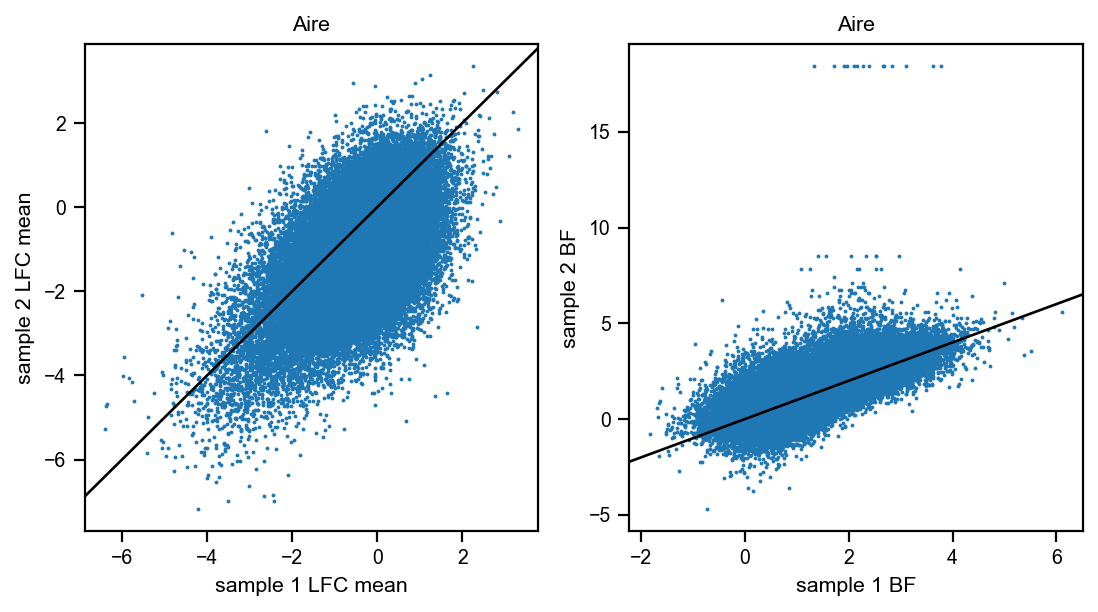

In [110]:
all_aire_1 = all_genes["Aire_1"]
all_aire_2 = all_genes["Aire_2"]

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
ax = sns.scatterplot(
    x=all_aire_1.lfc_mean,
    y=all_aire_2.lfc_mean,
    s=3,
    linewidth=0
)
ax.axline((0, 0), slope=1, c="black")
ax.set_title("Aire")
ax.set_xlabel("sample 1 LFC mean")
ax.set_ylabel("sample 2 LFC mean")

plt.subplot(1,2,2)
ax = sns.scatterplot(
    x=all_aire_1.bayes_factor,
    y=all_aire_2.bayes_factor,
    s=3,
    linewidth=0
)
ax.axline((0, 0), slope=1, c="black")
ax.set_title("Aire")
ax.set_xlabel("sample 1 BF")
ax.set_ylabel("sample 2 BF")
plt.show()

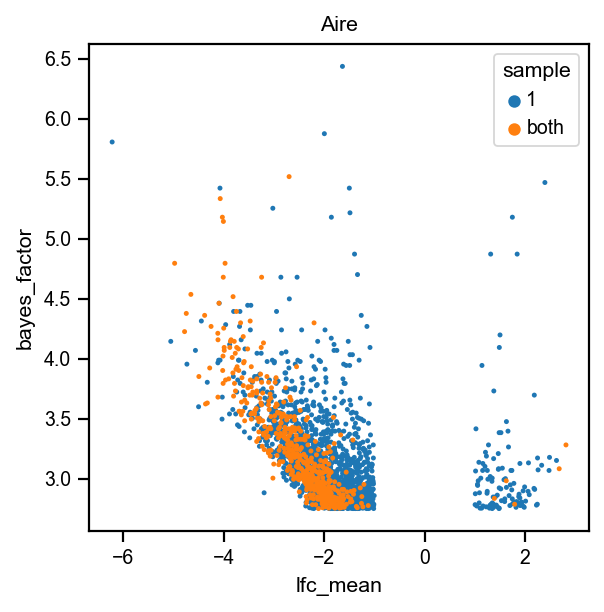

In [75]:
sns.scatterplot(
    aire_regulated[aire_regulated["sample"] == "1"],
    x="lfc_mean",
    y="bayes_factor",
    hue="sample",
    s=5,
    linewidth=0,
)
sns.scatterplot(
    aire_regulated[aire_regulated["sample"] == "both"],
    x="lfc_mean",
    y="bayes_factor",
    hue="sample",
    s=5,
    legend=None,
    linewidth=0,
)
plt.title("Aire")
plt.show()

## fezf2 regulated genes

In [112]:
aire_regulated[aire_regulated.index.isin(fezf2_regulated_genes)]

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2,cell_type,gene,abs_lfc,sample
Wfdc12,0.9726,0.0274,3.569430,2.904588e-06,0.000032,0.0,0.25,-3.589545,-3.631371,2.389751,...,0.006362,0.250708,True,Aire_KO vs Aire_WT,Aire_KO,Aire_WT,Aire-stage,Wfdc12,3.589545,both
Apoc3,0.9682,0.0318,3.415972,1.330303e-05,0.000054,0.0,0.25,-3.062101,-3.168644,2.381487,...,0.042848,0.551996,True,Aire_KO vs Aire_WT,Aire_KO,Aire_WT,Aire-stage,Apoc3,3.062101,both
Ly6g6c,0.9628,0.0372,3.253537,8.353773e-06,0.000043,0.0,0.25,-2.797163,-2.913490,2.113567,...,0.044535,0.279559,True,Aire_KO vs Aire_WT,Aire_KO,Aire_WT,Aire-stage,Ly6g6c,2.797163,both
Ttr,0.9618,0.0382,3.225971,6.141400e-06,0.000037,0.0,0.25,-2.591123,-2.752916,2.265369,...,0.076250,0.325812,True,Aire_KO vs Aire_WT,Aire_KO,Aire_WT,Aire-stage,Ttr,2.591123,both
Arg1,0.9514,0.0486,2.974311,5.742614e-06,0.000022,0.0,0.25,-2.295609,-2.395448,2.036343,...,0.028830,0.162085,True,Aire_KO vs Aire_WT,Aire_KO,Aire_WT,Aire-stage,Arg1,2.295609,both
F3,0.9488,0.0512,2.919458,4.317098e-06,0.000017,0.0,0.25,-2.216202,-2.205511,2.014553,...,0.013054,0.063752,True,Aire_KO vs Aire_WT,Aire_KO,Aire_WT,Aire-stage,F3,2.216202,both
Gsto1,0.9482,0.0518,2.907175,8.564288e-06,0.000039,0.0,0.25,-2.051612,-2.045758,1.655180,...,0.050776,0.259330,True,Aire_KO vs Aire_WT,Aire_KO,Aire_WT,Aire-stage,Gsto1,2.051612,both
Il18,0.9548,0.0452,3.050405,6.117358e-06,0.000032,0.0,0.25,-2.526017,-2.621787,2.519021,...,0.010588,0.056495,True,Aire_KO vs Aire_WT,Aire_KO,Aire_WT,Aire-stage,Il18,2.526017,1
Dnase1l2,0.9476,0.0524,2.895026,2.998711e-06,0.000014,0.0,0.25,-2.129936,-2.190470,1.991414,...,0.007105,0.022227,True,Aire_KO vs Aire_WT,Aire_KO,Aire_WT,Aire-stage,Dnase1l2,2.129936,1
Klk1b16,0.9456,0.0544,2.855455,9.195692e-06,0.000030,0.0,0.25,-2.001674,-2.057247,2.872903,...,0.016436,0.367321,True,Aire_KO vs Aire_WT,Aire_KO,Aire_WT,Aire-stage,Klk1b16,2.001674,1


In [113]:
aire_regulated["fezf2_microarray_de"] = aire_regulated.index.isin(fezf2_regulated_genes)

In [114]:
fezf2_regulated[fezf2_regulated.index.isin(fezf2_regulated_genes)]

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2,cell_type,gene,abs_lfc,sample
Wfdc15b,0.9742,0.0258,3.631242,0.000101,0.000010,0.0,0.25,3.116584,3.137970,2.054413,...,2.910578,0.074139,True,Fezf2_KO vs Fezf2_WT,Fezf2_KO,Fezf2_WT,Neuroendocrine,Wfdc15b,3.116584,both
Fabp9,0.9746,0.0254,3.647278,0.000055,0.000481,0.0,0.25,-3.020205,-3.025090,1.781434,...,0.012294,9.741510,True,Fezf2_KO vs Fezf2_WT,Fezf2_KO,Fezf2_WT,Mcell,Fabp9,3.020205,both
Ly6g6c,0.9604,0.0396,3.188521,0.001053,0.000236,0.0,0.25,2.535264,2.680308,2.609621,...,10.914701,2.964013,True,Fezf2_KO vs Fezf2_WT,Fezf2_KO,Fezf2_WT,Goblet,Ly6g6c,2.535264,both
Sbsn,0.9514,0.0486,2.974311,0.001813,0.000397,0.0,0.25,2.308945,2.449871,2.533952,...,28.822380,4.729518,True,Fezf2_KO vs Fezf2_WT,Fezf2_KO,Fezf2_WT,Goblet,Sbsn,2.308945,both
Ttr,0.9628,0.0372,3.253537,0.000006,0.000033,0.0,0.25,-2.306925,-2.325738,1.833261,...,0.000000,0.245567,True,Fezf2_KO vs Fezf2_WT,Fezf2_KO,Fezf2_WT,Mcell,Ttr,2.306925,both
Csrnp3,0.9544,0.0456,3.041175,0.000007,0.000030,0.0,0.25,-2.300672,-2.347621,1.683062,...,0.037869,0.339897,True,Fezf2_KO vs Fezf2_WT,Fezf2_KO,Fezf2_WT,Aire-stage,Csrnp3,2.300672,both
Krt10,0.9494,0.0506,2.931878,0.000340,0.001373,0.0,0.25,-2.200973,-2.218674,1.848260,...,2.680305,26.543821,True,Fezf2_KO vs Fezf2_WT,Fezf2_KO,Fezf2_WT,"Skin, basal",Krt10,2.200973,both
Dpp4,0.9504,0.0496,2.952892,0.000094,0.000021,0.0,0.25,2.122021,2.222861,1.552471,...,1.249566,0.249956,True,Fezf2_KO vs Fezf2_WT,Fezf2_KO,Fezf2_WT,Goblet,Dpp4,2.122021,both
Apoc3,0.9462,0.0538,2.867180,0.000061,0.000264,0.0,0.25,-2.099632,-2.078568,1.821261,...,0.232733,6.073342,True,Fezf2_KO vs Fezf2_WT,Fezf2_KO,Fezf2_WT,Mcell,Apoc3,2.099632,both
Smtnl1,0.9514,0.0486,2.974311,0.000041,0.000171,0.0,0.25,-2.091233,-2.123023,1.877143,...,0.375266,2.172583,True,Fezf2_KO vs Fezf2_WT,Fezf2_KO,Fezf2_WT,Gut/Liver,Smtnl1,2.091233,both


In [115]:
fezf2_regulated["fezf2_microarray_de"] = fezf2_regulated.index.isin(fezf2_regulated_genes)

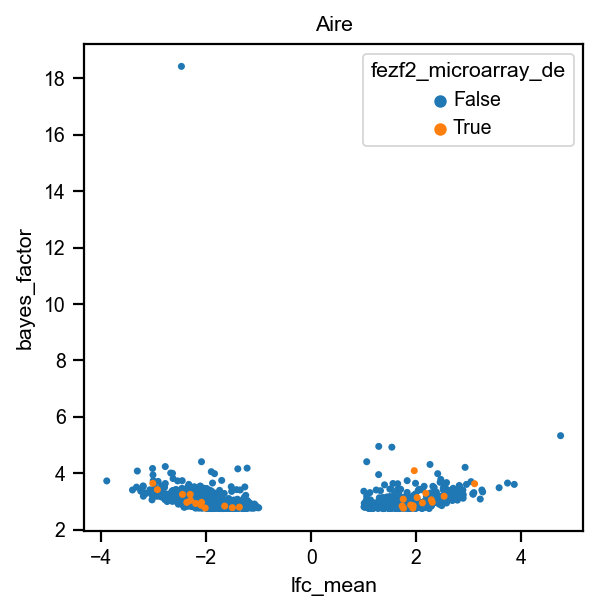

In [121]:
sns.scatterplot(
    fezf2_regulated[~fezf2_regulated.fezf2_microarray_de],
    x="lfc_mean",
    y="bayes_factor",
    hue="fezf2_microarray_de",
    s=10,
    linewidth=0
)
sns.scatterplot(
    fezf2_regulated[fezf2_regulated.fezf2_microarray_de],
    x="lfc_mean",
    y="bayes_factor",
    palette=["tab:orange"],
    hue="fezf2_microarray_de",
    s=10,
    linewidth=0
)
plt.title("Aire")
plt.show()

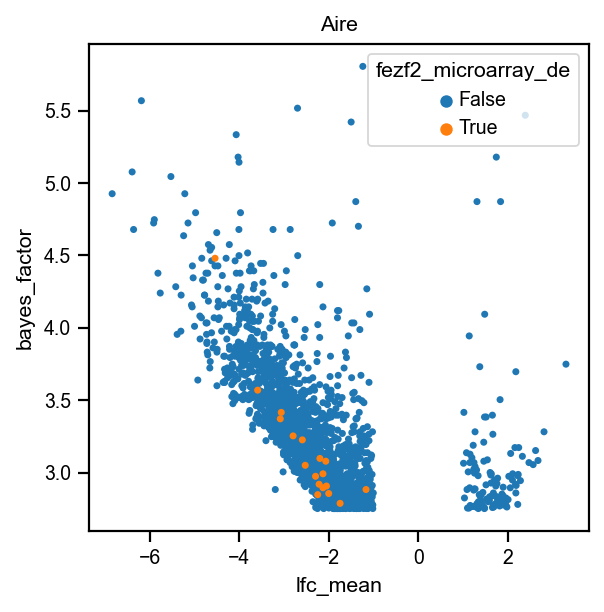

In [120]:
sns.scatterplot(
    aire_regulated[~aire_regulated.fezf2_microarray_de],
    x="lfc_mean",
    y="bayes_factor",
    hue="fezf2_microarray_de",
    s=10,
    linewidth=0
)
sns.scatterplot(
    aire_regulated[aire_regulated.fezf2_microarray_de],
    x="lfc_mean",
    y="bayes_factor",
    palette=["tab:orange"],
    hue="fezf2_microarray_de",
    s=10,
    linewidth=0
)
plt.title("Aire")
plt.show()

# Num regulated genes comparison

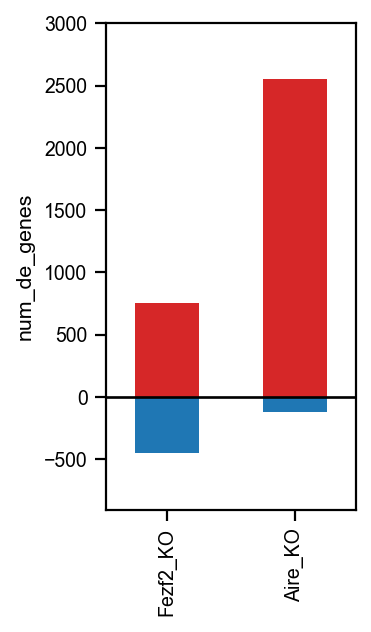

In [118]:
plotData = {}
plotData["up"] = [sum(fezf2_regulated.lfc_mean > 0), sum(aire_regulated.lfc_mean > 0)]
plotData["down"] = [sum(fezf2_regulated.lfc_mean < 0), sum(aire_regulated.lfc_mean < 0)]

plotData = pd.DataFrame(plotData, index=["Fezf2_KO", "Aire_KO"])

fig=plt.figure(figsize=(2,4))
plt.bar(x=plotData.index, height=plotData.down, color='tab:red', width=0.5)
plt.bar(x=plotData.index, height=-plotData.up, color='tab:blue', width=0.5)
plt.xticks([0,1], plotData.index, rotation='vertical')
plt.ylabel("num_de_genes")
plt.axhline(y=0, c="black")
plt.margins(0.15)
plt.show()

In [119]:
print(f"Aire KO up: {aire_regulated[aire_regulated.lfc_mean > 0].shape[0]}")
print(f"Aire KO down: {aire_regulated[aire_regulated.lfc_mean < 0].shape[0]}")
print(f"Fezf2 KO up: {fezf2_regulated[fezf2_regulated.lfc_mean > 0].shape[0]}")
print(f"Fezf2 KO down: {fezf2_regulated[fezf2_regulated.lfc_mean < 0].shape[0]}")

Aire KO up: 118
Aire KO down: 2551
Fezf2 KO up: 454
Fezf2 KO down: 751
